## 1. Set up the basics

In [0]:
# set up S3 bucket

bucket = 'telco-project'
prefix = 'sagemaker/ds'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

ModuleNotFoundError: ignored

In [0]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker 
from sagemaker.predictor import csv_serializer 
from sklearn.model_selection import train_test_split

## 2. Import data 

In [0]:
df = pd.read_csv('Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', 100)
df # 7043 row x 21 columns

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [0]:
# see column names
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [0]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [0]:
# fot some reason, `TotalCharges` is defined as object data type, so it needs to 
# be converted into float data type 

df['TotalCharges'] = df['TotalCharges'].convert_objects(convert_numeric=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


**Definition of features (from Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn)**
- **`CustomerID`**: Customer ID
- **`Gender`**: Whether the customer is a male or a female
- **`SeniorCitizen`**: Whether the customer is a senior citizen or not (1, 0)
- **`Partner`**: Whether the customer has a partner or not (Yes, No)
- **`Dependents`**: Whether the customer has dependents or not (Yes, No)
- **`Tenure`**: Number of months the customer has stayed with the company
- **`PhoneService`**: Whether the customer has a phone service or not (Yes, No)
- **`MultipleLines`**: Whether the customer has multiple lines or not (Yes, No, No phone service)
- **`InternetService`**: Customer’s internet service provider (DSL, Fiber optic, No)
- **`OnlineSecurity`**: Whether the customer has online security or not (Yes, No, No internet service)
- **`OnlineBackup`**: Whether the customer has online backup or not (Yes, No, No internet service)
- **`DeviceProtection`**: Whether the customer has device protection or not (Yes, No, No internet service)
- **`TechSupport`**: Whether the customer has tech support or not (Yes, No, No internet service)
- **`StreamingTV`**: Whether the customer has streaming TV or not (Yes, No, No internet service)
- **`StreamingMovies`**: Whether the customer has streaming movies or not (Yes, No, No internet service)
- **`Contract`**: The contract term of the customer (Month-to-month, One year, Two year)
- **`PaperlessBilling`**: Whether the customer has paperless billing or not (Yes, No)
- **`PaymentMethod`**: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- **`MonthlyCharges`**: The amount charged to the customer monthly
- **`TotalCharges`**: The total amount charged to the customer
- **`Churn`**: Whether the customer churned or not (Yes or No)

## 3. data exploration  & visualization

### 3.1 check missing values

In [0]:
# check duplicate data 
df = df.drop_duplicates()
df.shape # (7043, 21), no duplicate rows

(7043, 21)

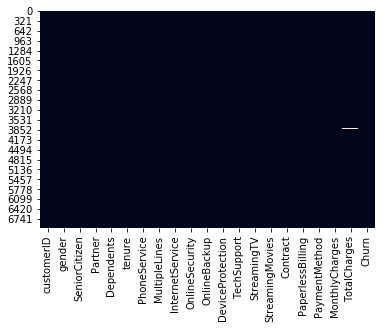

In [0]:
# check missing values via heatmap
sns.heatmap(df.isnull(), cbar=False) #  data viz shows there are a few missing values in `TotalCharges` column 

In [0]:
# verify via numeric summary
df.isnull().sum() # 11 missing values in the `TotalCharges` column

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [0]:
# remove missing values from dataset
df.dropna(inplace=True)
df.shape 

(7032, 21)

### 3.2 Compare cutomer churn between genders

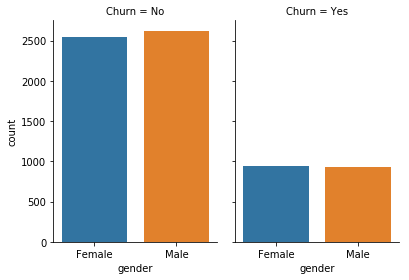

In [0]:
g = sns.catplot(x="gender", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

# no significant difference between genders with regard to churns

### 3.3  Check the relation between having a partner & churn 

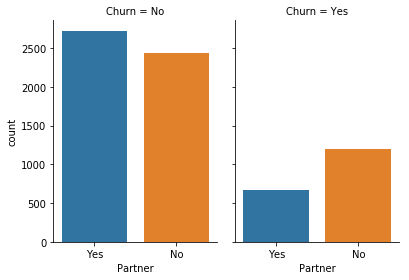

In [0]:
g = sns.catplot(x="Partner", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7);

# There different patterns in the churn and not churn group. The plot shows that having 
# a partner may tend to lead to a churn


### 3.4  Check the relation between having dependents & churn 

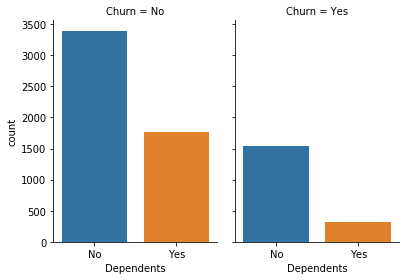

In [0]:
g = sns.catplot(x="Dependents", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7);

# The pattern in the chrun and no churn group is similar; Therefore having dependents may not be a 
# effective feature

### 3.5 Check the relation between using phone service & churn

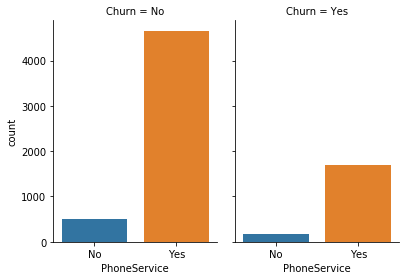

In [0]:
g = sns.catplot(x="PhoneService", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7);

# Once again, the pattern is similar between the two groups, suggesting having phone service 
# may not be an effective feature. Churn or no churn, there are just more people subscribing to 
# phone service

### 3.6 Check use multiple lines & churn

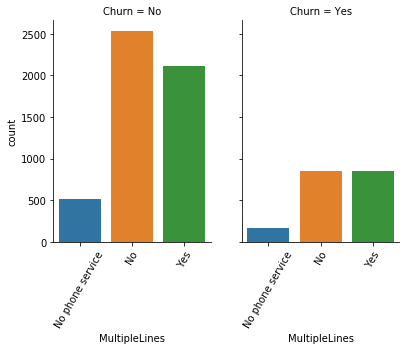

In [0]:
g = sns.catplot(x="MultipleLines", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

g.set_xticklabels(rotation=60)

# No significant difference though using multiple lines seems to yield more no churn

### 3.7 Check use fiber optic & churn

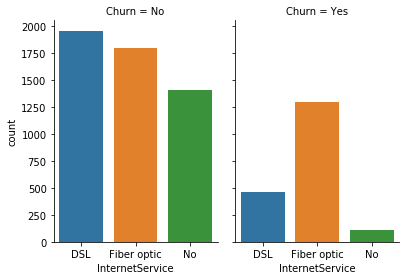

In [0]:
g = sns.catplot(x="InternetService", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7);

# it is obvious that use of fiber optic leads to higher churn compared to DSL

### 3.8 Check use of internet online security & churn

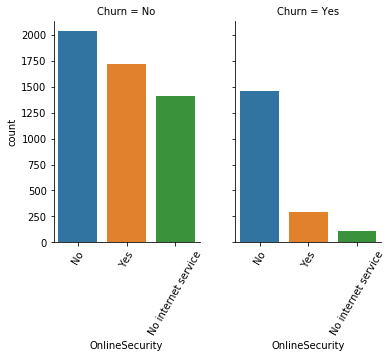

In [0]:
g = sns.catplot(x="OnlineSecurity", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

g.set_xticklabels(rotation=60)

# No significant difference

### 3.9 Check use of online backup service & churn

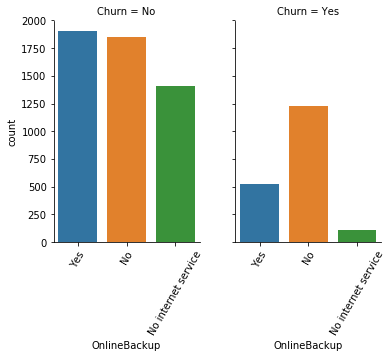

In [0]:
g = sns.catplot(x="OnlineBackup", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

g.set_xticklabels(rotation=60)

# it seems not use online backup yields higher churn. However, not using it does not lead to 
# prticularly higher retenton either. This may suggest that some specific users encountered some problem
# when not using this service

### 3.10 Check the use of device protection & churn

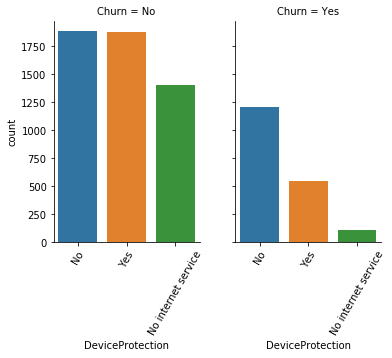

In [0]:
g = sns.catplot(x="DeviceProtection", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

g.set_xticklabels(rotation=60)

# while use and not use this service lead to similar no churn, not using this service 
# seems to lead higher churn

### 3.11 Check use of tech support & churn 

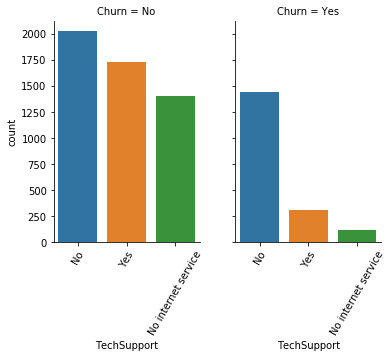

In [0]:
g = sns.catplot(x="TechSupport", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

g.set_xticklabels(rotation=60)

# the pattern across three sub-groups is consistant, it shows that users may have a mixed 
# experience of using this service as use this service also doesn't lead to more no churn

### 3.12 Check use of streaming TC service & churn

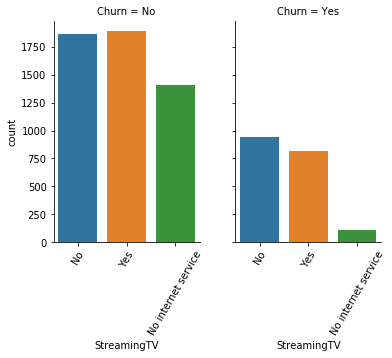

In [0]:
g = sns.catplot(x="StreamingTV", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7);

g.set_xticklabels(rotation=60)

# not use streaming TV service may lead to higher churn 

### 3.13 Check the use of streaming movies & churn 

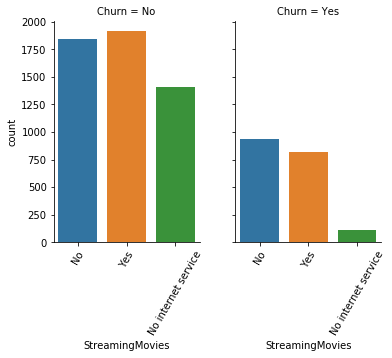

In [0]:
g = sns.catplot(x="StreamingMovies", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

g.set_xticklabels(rotation=60)

# not using streaming movies may lead to higher churn

### 3.14 Relation between contract length & churn 

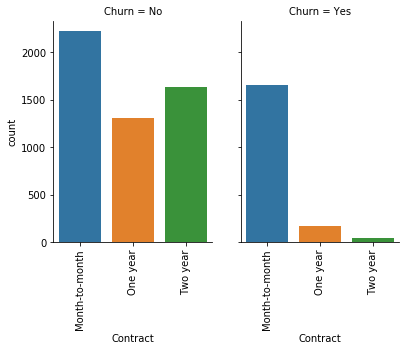

In [0]:
g = sns.catplot(x="Contract", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)

g.set_xticklabels(rotation=90)

# Comparatively, 2-year contract yields lowest churn, while monthly contract has a mixed result of high 
# churn and no churn. This may just reflects that nature of monthly contract users, who tend to drop the 
# service faster since they may just be using the service temporarily

### 3.15 Use of paperless bills & churn 

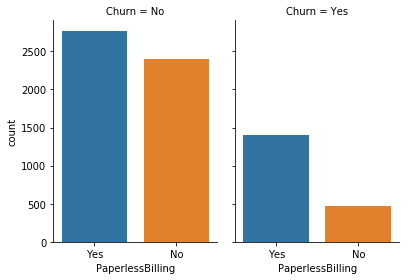

In [0]:
g = sns.catplot(x="PaperlessBilling", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7);

# no significant effect of using paperless bills

### 3.16 Payment method & churn 

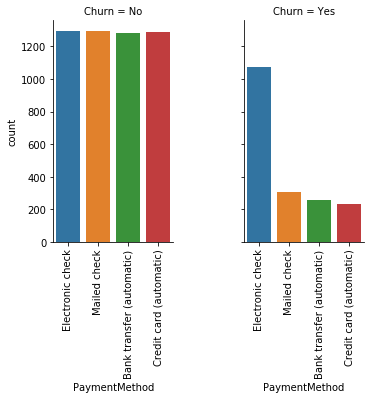

In [0]:
g = sns.catplot(x="PaymentMethod", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7)
g.set_xticklabels(rotation=90)

# It looks like eletronic check is not in favor of customer retention, while other
# payment methods are don't particularly lead to high churn

### 3.17 Check the relaton between senior customer with churn

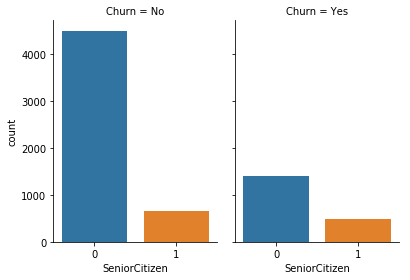

In [0]:
# recode column variable
mapping = {0: 'not senior', 1: 'senior'}
df.replace({'SeniorCitizen': mapping})

g = sns.catplot(x="SeniorCitizen", col="Churn",
                data=df, kind="count", 
                 height=4, aspect=.7);

# senior user account for the minority of users, and there is no significant effect
# on the churn


### 3.18 Check relaton between continuous features & churn 

In [0]:
# subset dataframe to get continuous features
df_cont = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]
# recode `Churn` column 
mapping = {'No': 0, 'Yes': 1}
df_cont = df_cont.replace({'Churn': mapping})

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


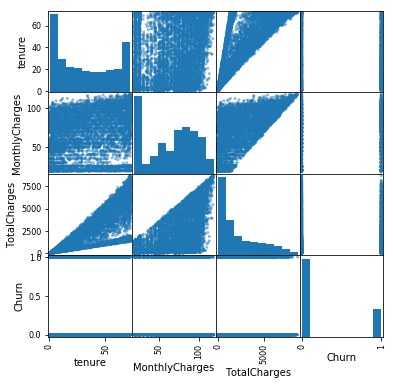

In [0]:
display(df.corr())
pd.plotting.scatter_matrix(df_cont, figsize=(6, 6))
plt.show()

# Data distribution summry:
# 1. tenure: there is an concentration in the head and tail. While the a large number of short-tenure users make intuitive
# sense, it is worth checking if there is abnormal outliers among the long-tenure users
# 2. Monthly Charges' distribution makes sense
# 3. In general, there churn is about half the number of no churn
# Data correlaton:
# ThE only obvious correlation is between tenure and total charge, also, month charge and total charge. This makes
# intuitive sense as the longer you stay in the company's service, the more in total you spend


### 3.19  Check outliers (continuous features) 

In [0]:
# Compare mean, median, and max values to examine outliers
df_cont.loc[:, df_cont.columns != 'Churn'].describe()
# summary: For both continuous features, no upper bound outliers are detected (no big gap 
# between their mean and median, nor are their the max values too abnormal)


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


### Quick summary:
* 1. Most of the features are categorical
* 2. 11 missing values in the TotalCharges column
* 3. Features that potentially impact churn include:
    * having a partner
    * use of fiber optic 
    * online backup 
    * device protection 
    * streaming TV service 
    * streaming movie service
* 4. Month charges correlates with total charges, so does tenure with total charges
* 5. No dramatic outliers in the continuous variables


### 4. Predict churn with various models

In [0]:
# recode and reshape dataframe for modeling

# recode the `SeniorCitizen` column
mapping = {0: 'No', 1: 'Yes'}
df = df.replace({'SeniorCitizen': mapping})
df.columns = df.columns.str.capitalize()
df.dtypes 

Customerid           object
Gender               object
Seniorcitizen        object
Partner              object
Dependents           object
Tenure                int64
Phoneservice         object
Multiplelines        object
Internetservice      object
Onlinesecurity       object
Onlinebackup         object
Deviceprotection     object
Techsupport          object
Streamingtv          object
Streamingmovies      object
Contract             object
Paperlessbilling     object
Paymentmethod        object
Monthlycharges      float64
Totalcharges        float64
Churn                object
dtype: object

### 4.1 Split data into train, validaton, test (60%, 20%,  20%)

In [0]:
y = df.pop('Churn').to_frame()
X = df

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y,stratify=y, test_size=0.4, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5, random_state=1)
# X_train.shape (4225, 19); X_val.shape (1409, 19); X_test.shape(1409, 19)

In [0]:
# also, recode y (target feature) into numeric binary values
mapping = {'No': 0, 'Yes': 1}
y_train = y_train.replace({'Churn': mapping})
y_val = y_val.replace({'Churn': mapping})
y_test = y_test.replace({'Churn': mapping})

In [0]:
y_train['Churn'].value_counts() 

0    3098
1    1121
Name: Churn, dtype: int64

In [0]:
y_val['Churn'].value_counts()

0    1033
1     374
Name: Churn, dtype: int64

In [0]:
y_test['Churn'].value_counts() 

0    1032
1     374
Name: Churn, dtype: int64

**Ratio of the churn v.s no churn is verified across train, validaton, test set (about 1:3)**

### 4.2 Save train, validation, test data & upload to S3

In [0]:
X_train.to_csv('X_train.csv', header=False, index=False)
y_train.to_csv('y_train.csv', header=False, index=False)
X_val.to_csv('X_val.csv', header=False, index=False)
y_val.to_csv('y_val.csv', header=False, index=False)
X_test.to_csv('X_test.csv', header=False, index=False)
y_test.to_csv('y_test.csv', header=False, index=False)

In [0]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/X_train.csv')).upload_file('X_train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/y_train.csv')).upload_file('y_train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'val/X_val.csv')).upload_file('X_val.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'val/y_val.csv')).upload_file('y_val.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/X_test.csv')).upload_file('X_test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/y_test.csv')).upload_file('X_test.csv')

### 4.3 XGBoost model training

In [0]:
# create a model continer
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')
# create pointers for data 
s3_input_X_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/X_train'.format(bucket, prefix), content_type='csv')
s3_input_y_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/y_train'.format(bucket, prefix), content_type='csv')
s3_input_X_val = sagemaker.s3_input(s3_data='s3://{}/{}/val/X_val'.format(bucket, prefix), content_type='csv')
s3_input_y_val = sagemaker.s3_input(s3_data='s3://{}/{}/val/y_val'.format(bucket, prefix), content_type='csv')
s3_input_X_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/X_test'.format(bucket, prefix), content_type='csv')
s3_input_y_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/y_test'.format(bucket, prefix), content_type='csv')


In [0]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)


xgb.set_hyperparameters(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)

xgb.fit(s3_input_X_train, s3_input_y_train)


### Deploy XGBoost model

In [0]:
# deploy trained model as endpoint
xgb_predictor = xgb.deploy(initial_instance=1, 
                          instance_type='ml.m4.xlarge')

In [0]:
# see model performance on validation set

predicted_y_val = xgb_predictor.predict(s3_input_X_val)
pd.crosstab(s3_input_y_val['Churn'], np.round(predicted_y_val))